In [3]:
import pandas as pd
import ffn
import matplotlib as mp
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
tickers = ['REE','HCM','FMC','SFC','TCW','VNR']
start = '2016-01-01' #dt.date(2018,1,1)
end = '2020-10-01' #dt.date(2020,10,1)

In [6]:
prices = (
    pd.concat([pd.read_csv(f'data/{ticker}.csv',index_col='date',parse_dates=True)['adj_close'].rename(ticker) for ticker in tickers],axis=1,sort=True)
)
prices = prices.dropna()
prices

,REE,HCM,FMC,SFC,TCW,VNR
date,,,,,,
2017-06-26,31.88,19.34,13.12,19.79,17.18,19.34
2017-06-27,31.49,19.21,13.12,19.44,17.42,19.01
2017-06-28,32.14,18.93,13.12,19.44,16.94,19.42
2017-06-29,32.22,19.06,13.12,19.44,15.23,19.42
2017-06-30,32.05,19.06,13.16,19.44,14.49,19.42
...,...,...,...,...,...,...
2020-10-12,41.70,22.15,32.75,23.25,22.50,19.40
2020-10-13,41.65,22.00,33.30,23.75,22.50,19.40
2020-10-14,41.10,22.35,32.35,23.75,22.50,19.60


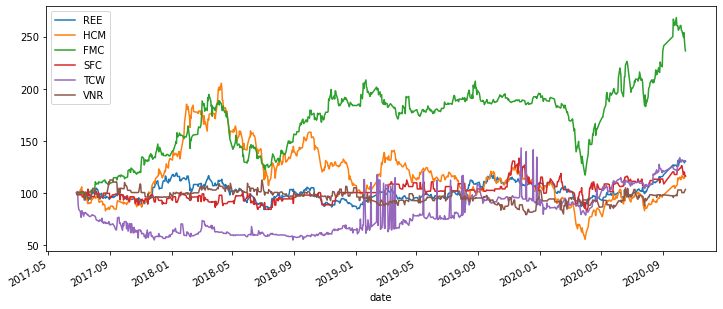

In [7]:
prices.rebase().plot(figsize=(12,5))

In [8]:
returns = prices.to_returns().dropna()

In [55]:
stats = prices.calc_stats()
stats.set_riskfree_rate(0.05)
stats.display()

/Users/nhacheat/anaconda3/lib/python3.8/site-packages/ffn/core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


Stat                 REE         HCM         FMC         SFC         TCW         VNR
-------------------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2017-06-26  2017-06-26  2017-06-26  2017-06-26  2017-06-26  2017-06-26
End                  2020-10-16  2020-10-16  2020-10-16  2020-10-16  2020-10-16  2020-10-16
Risk-free rate       5.00%       5.00%       5.00%       5.00%       5.00%       5.00%

Total Return         30.49%      16.08%      136.28%     16.22%      30.38%      3.41%
Daily Sharpe         0.26        0.21        0.81        0.20        0.80        0.11
Daily Sortino        0.44        0.35        1.38        0.30        1.47        0.18
CAGR                 8.38%       4.61%       29.69%      4.65%       8.35%       1.02%
Max Drawdown         -29.60%     -72.92%     -43.80%     -38.83%     -46.53%     -29.50%
Calmar Ratio         0.28        0.06        0.68        0.12        0.18        0.03

MTD                  3.48%   

In [10]:
returns.corr().as_format('.2f')

,REE,HCM,FMC,SFC,TCW,VNR
REE,1.00,0.50,0.32,0.06,0.02,0.10
HCM,0.50,1.00,0.38,0.10,0.09,0.13
FMC,0.32,0.38,1.00,0.12,0.00,0.05
SFC,0.06,0.10,0.12,1.00,-0.05,0.06
TCW,0.02,0.09,0.00,-0.05,1.00,0.02
VNR,0.10,0.13,0.05,0.06,0.02,1.00


<module 'matplotlib.pyplot' from '/Users/nhacheat/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

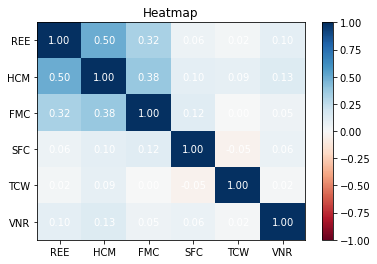

In [11]:
returns.plot_corr_heatmap()

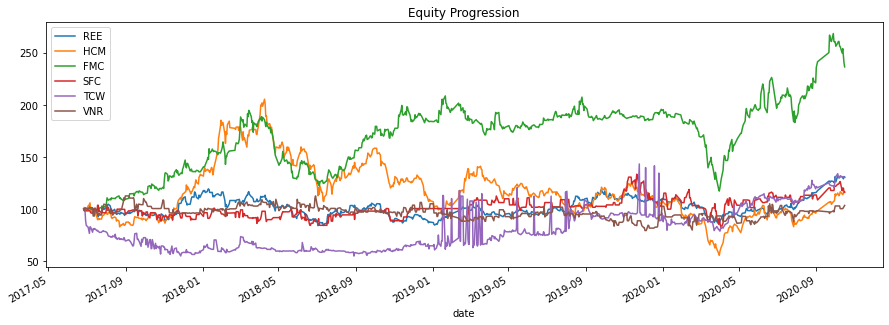

In [12]:
stats.plot()

In [14]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import numpy as np

In [21]:
weights = [1/len(prices.columns)]*len(prices.columns)
weights = np.array(weights)
weights

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [30]:
returns = prices.pct_change()
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()
cov_matrix

,REE,HCM,FMC,SFC,TCW,VNR
REE,0.000308,0.000237,1.224495e-04,0.000028,4.464980e-05,0.000046
HCM,0.000237,0.000731,2.213462e-04,0.000070,2.444169e-04,0.000093
FMC,0.000122,0.000221,4.644047e-04,0.000066,4.109344e-07,0.000030
SFC,0.000028,0.000070,6.642316e-05,0.000651,-1.213570e-04,0.000042
TCW,0.000045,0.000244,4.109344e-07,-0.000121,1.104656e-02,0.000064
VNR,0.000046,0.000093,3.005642e-05,0.000042,6.382897e-05,0.000672


In [32]:
pf_returns = round(np.sum(mean_daily_returns*weights)*252,3)
pf_std_dev = round(np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights))*np.sqrt(252)),3)
pf_returns,pf_std_dev

(0.365, 0.085)

In [33]:
print("Expected annualized return: " + "{:.1%}".format(pf_returns))
print("Volatility: " + "{:.1%}".format(pf_std_dev))

Expected annualized return: 36.5%
Volatility: 8.5%


In [45]:
# Calculate expected returns and sample covariance
hist_mean_return = expected_returns.mean_historical_return(prices)
#raw_weight = weights
covar = risk_models.sample_cov(prices)
hist_mean_return

REE    0.086096
HCM    0.047365
FMC    0.305844
SFC    0.047755
TCW    0.085824
VNR    0.010469
dtype: float64

In [44]:
# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(hist_mean_return,covar)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('REE', 0.0), ('HCM', 0.0), ('FMC', 0.99045), ('SFC', 0.0), ('TCW', 0.00955), ('VNR', 0.0)])
Expected annual return: 30.4%
Annual volatility: 33.9%
Sharpe Ratio: 0.84


(0.3037427187205031, 0.33920627302091166, 0.8364901869105784)

In [56]:
ema_returns = ema_historical_return(prices)
ef = EfficientFrontier(ema_returns,covar)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)
ema_returns

OrderedDict([('REE', 0.33556), ('HCM', 0.0), ('FMC', 0.3089), ('SFC', 0.12294), ('TCW', 0.15448), ('VNR', 0.07812)])
Expected annual return: 81.1%
Annual volatility: 31.6%
Sharpe Ratio: 2.51


REE    0.330133
HCM    0.242270
FMC    0.410330
SFC    0.208585
TCW    3.443971
VNR    0.204405
Name: 2020-10-16 00:00:00, dtype: float64

In [53]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(prices)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000000)#100,000,000
allocation, leftover = da.lp_portfolio()
print("Discrete allocation: ", allocation)
print("Funds remaining: ${:.2f}".format(leftover))
print(latest_prices)

Discrete allocation:  {'REE': 806634, 'FMC': 996452, 'SFC': 534522, 'TCW': 689643, 'VNR': 390600}
Funds remaining: $4.40
REE    41.60
HCM    22.45
FMC    31.00
SFC    23.00
TCW    22.40
VNR    20.00
Name: 2020-10-16 00:00:00, dtype: float64


In [40]:
from pypfopt.expected_returns import ema_historical_return

ema_returns = ema_historical_return(prices)
ema_returns

REE    0.330133
HCM    0.242270
FMC    0.410330
SFC    0.208585
TCW    3.443971
VNR    0.204405
Name: 2020-10-16 00:00:00, dtype: float64

In [62]:
market = prices['VNINDEX']
df = prices.loc[:,prices.columns !='VNINDEX']
#df.loc[:, df.columns != 'b']
type(market)

pandas.core.series.Series

In [59]:
from pypfopt.expected_returns import capm_return

capm_return = capm_return(prices,risk_free_rate=0.05)
ef = EfficientFrontier(capm_return,covar)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)
capm_return

OrderedDict([('REE', 0.21829), ('HCM', 0.1259), ('FMC', 0.1756), ('SFC', 0.17406), ('TCW', 0.13424), ('VNR', 0.17191)])
Expected annual return: 31.9%
Annual volatility: 29.3%
Sharpe Ratio: 1.02


REE    0.140331
HCM    0.233627
FMC    0.154037
SFC    0.134464
TCW    1.346426
VNR    0.158803
Name: mkt, dtype: float64